## Spam & Ham

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [32]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [33]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [34]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/>
<hr style="border: 1px solid #fdb515;" />

# Initial Analysis



In [35]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



Comments:
I think the most evident one is how both emails are structured. The first one uses natural language while the other is in a weird HTML format. Besides the format, the topics give it away why might one be spam and the other ham; the ham email it's informative and attaches some links, on the other hand the spam email is flashy and wants to promote what seems to be a fake medical product. 

<!-- END QUESTION -->

## Training-Validation Split


In [36]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)



### Feature Engineering



In [37]:
def words_in_texts(words, texts):
    

    #contains the word or not 
     #def contains_or_not(words, texts): 
     #   if texts.str.contains(words): 
     #       return 1
     #   else: 
     #       return 0
         
    #creates a 2D array with the specifications     
    #array = np.zeros((len(words)), len(texts)))
    
    #indicator_array = np.column_stack([texts.str.contains(words) for word in words])
    #return indicator_array
                

    if texts.empty: 
        return np.zeros((len(texts), len(words)))
        
    indicator_array = np.column_stack([texts.str.contains(word) for word in words])
    return indicator_array 

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: EDA



In [39]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


Text(0.5, 0, 'Emails')

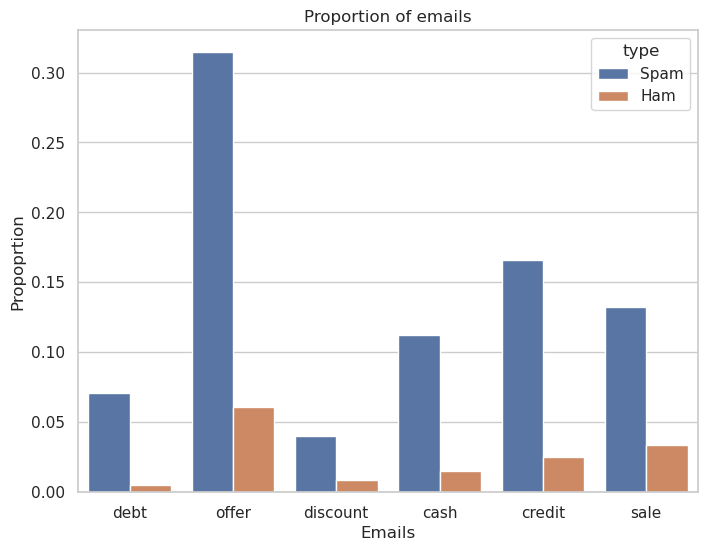

In [57]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.

s_words = ['debt', 'offer', 'discount', 'cash', 'credit', 'sale']
new_matrix = words_in_texts(s_words, original_training_data['email'])
new_matrix_df = pd.DataFrame(new_matrix, columns=s_words)

new_matrix_df['spam'] = original_training_data['spam']

var1 = []
for w in s_words: 
    spam1 = new_matrix_df[new_matrix_df['spam'] == 1][w].mean()
    var1.append({'type' : 'Spam', 'word': w, 'proportion': spam1})

    spam0 = new_matrix_df[new_matrix_df['spam'] == 0][w].mean()
    var1.append({'type' : 'Ham', 'word': w, 'proportion': spam0})

var1_df = pd.DataFrame(var1)
plt.figure(figsize=(8,6))
sns.barplot(x='word', y = 'proportion', hue='type', data=var1_df)
plt.title('Proportion of emails')
plt.ylabel('Propoprtion')
plt.xlabel('Emails')



<!-- END QUESTION -->

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<br/>
<hr style="border: 1px solid #fdb515;" />

#  Basic Classification



In [58]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam'].values

X_train[:5], Y_train[:5]

(array([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True, False]]),
 array([0, 0, 0, 0, 0]))

In [60]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression()

my_model.fit(X_train, Y_train)


training_accuracy = sum(my_model.predict(X_train) == Y_train)/len(Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [62]:
zero_predictor_fp = 0
zero_predictor_fn = np.sum(Y_train == 1)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [64]:
zero_predictor_acc = np.sum((Y_train == 0) / len(Y_train))
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

In [66]:
Y_train_hat = my_model.predict(X_train)

TP = np.sum((Y_train == 1) & (Y_train_hat == 1))
TN = np.sum((Y_train == 0) & (Y_train_hat == 0))
FP = np.sum((Y_train == 0) & (Y_train_hat == 1))
FN = np.sum((Y_train == 1) & (Y_train_hat == 0))
logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_fpr = FP / (TN + FP) 

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=219, TN=5473, FP=122, FN=1699
logistic_predictor_precision=0.64, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02
